In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import dotenv
import pvlib

dotenv.load_dotenv()

True

In [124]:
# Werte zur Eingabe für das ganze Dokument

# Ortsdaten in Form von Latitude und Longitude
latitude = 53.550383    # Hamburg Rathausmarkt
longitude = 9.992369    # Hamburg Rathausmarkt

# Zeitspanne für die Datenabfrage
start_date = 20250101  # Startdatum
end_date = 20251231    # Enddatum

# Parameter für das Balkonkraftwerk
balkonkraftwerk_fläche = 3            # Fläche in Quadratmetern
balkonkraftwerk_azimuth = 180           # Ausrichtung nach Süden
balkonkraftwerk_tilt = 30               # Neigungswinkel in Grad
balkonkraftwerk_leistung_pro_qm = 200   # Leistung pro Quadratmeter in Watt
balkonraftwerk_wirkungsgrad = 0.15      # Wirkungsgrad des Balkonkraftwerks

# Parameter für den Wechselrichter
wechselrichter_wirkungsgrad = 0.95       # Wirkungsgrad des Wechselrich
wechselrichter_leistungsgrenze = 800    # Maximale Leistung des Wechselrichters in Watt

In [115]:
from entsoe import EntsoePandasClient

client = EntsoePandasClient(api_key=os.getenv('TOKEN'))

start = pd.Timestamp('20250101', tz='Europe/Brussels')
end = pd.Timestamp('20260101', tz='Europe/Brussels')
country_code = 'DE_LU'  # Belgium
country_code_from = 'DE_LU'  # France
country_code_to = 'DE_LU' # Germany-Luxembourg
type_marketagreement_type = 'A01'
contract_marketagreement_type = "A01"
process_type = 'A44'
resolution = '15min'
sequence = 2

# methods that return Pandas Series
price_series = client.query_day_ahead_prices_local(country_code=country_code,
                                    sequence=sequence,
                                    start=start,
                                    end=end,
                                    resolution=resolution,)

# Resampling der Daten auf stündlich und Umwandeln des Index in Datum sowie Lokalisieren auf UTC
price_series = price_series.resample('h').mean() # Resampling auf stündlich
price_series.index = price_series.index.tz_convert('UTC') # Lokalisieren auf UTC
price_series.name = 'Price' # Spaltenname setzen

# Überprüfen der Datentypen und Ausgabe sowie Anzahl der NaN-Werte
print('Datentypen:\n', price_series.dtypes)
print('Anzahl NaN-Wert:\n', price_series.isna().sum())
print(price_series.head())

Datentypen:
 float64
Anzahl NaN-Wert:
 0
2024-12-31 23:00:00+00:00   -0.1150
2025-01-01 00:00:00+00:00   -0.5150
2025-01-01 01:00:00+00:00   -1.4775
2025-01-01 02:00:00+00:00   -2.6000
2025-01-01 03:00:00+00:00   -6.5000
Freq: h, Name: Price, dtype: float64


In [116]:
# Abruf der relevanten Daten für die Sonneneinstrahlung bei Open Meteo
# https://open-meteo.com/en/docs/historical-weather-api?

website_url_meteo = "https://archive-api.open-meteo.com/v1/archive"

# Parameter für den API-Aufruf
params = {
	"latitude": latitude,
	"longitude": longitude,
	"start_date": "2025-01-01",
	"end_date": "2025-12-31",
	"hourly": ["shortwave_radiation", "diffuse_radiation", "direct_normal_irradiance"],
}

# API-Anfrage senden
response = requests.get(website_url_meteo, params=params)

# Statuscode der Antwort ausgeben
print("Statuscode:", response.status_code)

# Antwort als JSON in Pandas DF ausgeben (falls erfolgreich)
if response.status_code == 200:
    data = response.json()
    parameter = data['hourly']
    df_meteo = pd.DataFrame({
		'Datum':pd.to_datetime(parameter['time']),
        'Global_Radiation':parameter['shortwave_radiation'],        # Watt pro m2
        'Direct_Radiation':parameter['direct_normal_irradiance'],   # Watt pro m2
        'Diffuse_Radiation':parameter['diffuse_radiation']          # Watt pro m2
	})

    # Datum als Index setzen und auf UTC lokalisieren
    df_meteo['Datum'] = pd.to_datetime(df_meteo['Datum']).dt.tz_localize('UTC')
    df_meteo.set_index('Datum', inplace=True)

    # Ausage über den erfolgreichen Abruf der Daten
    print('Daten erfolgreich im df_meteo gespeichert.')

else:
    print("Fehler beim Abrufen der Daten. Statuscode:", response.status_code)
    print("Fehlertext:", response.text)

# Ausgabe der ersten Zeilen des DataFrames und der Datentypen sowie Prüfen auf NaN-Werte
print('Datentypen:\n', df_meteo.dtypes)
print('Anzahl NaN-Werte:\n', df_meteo.isna().sum())
print(df_meteo.head())

Statuscode: 200
Daten erfolgreich im df_meteo gespeichert.
Datentypen:
 Global_Radiation     float64
Direct_Radiation     float64
Diffuse_Radiation    float64
dtype: object
Anzahl NaN-Werte:
 Global_Radiation     0
Direct_Radiation     0
Diffuse_Radiation    0
dtype: int64
                           Global_Radiation  Direct_Radiation  \
Datum                                                           
2025-01-01 00:00:00+00:00               0.0               0.0   
2025-01-01 01:00:00+00:00               0.0               0.0   
2025-01-01 02:00:00+00:00               0.0               0.0   
2025-01-01 03:00:00+00:00               0.0               0.0   
2025-01-01 04:00:00+00:00               0.0               0.0   

                           Diffuse_Radiation  
Datum                                         
2025-01-01 00:00:00+00:00                0.0  
2025-01-01 01:00:00+00:00                0.0  
2025-01-01 02:00:00+00:00                0.0  
2025-01-01 03:00:00+00:00          

In [117]:
# Abrufen des Sonnenstands mit pvlib

# Zeitstempel für die Berechnung des Sonnenstands
times = pd.date_range(start='2025-01-01', end='2025-12-31', freq='h', tz='UTC')

# Berechnung des Sonnenstands
solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)

# Umwandeln in DataFrame, Setzen des Index auf Datum und Lokalisieren auf UTC
df_solar_position = solpos.copy()
df_solar_position.index.name = 'Datum'
df_solar_position.index = df_solar_position.index.tz_convert('UTC')


# Ausgabe der Datentypen, der Anzahl der NaN-Werte und der ersten Zeilen des DataFrames
print('Datentypen:\n', df_solar_position.dtypes)
print('Anzahl NaN-Werte:\n', df_solar_position.isna().sum())
print(df_solar_position.head())

Datentypen:
 apparent_zenith       float64
zenith                float64
apparent_elevation    float64
elevation             float64
azimuth               float64
equation_of_time      float64
dtype: object
Anzahl NaN-Werte:
 apparent_zenith       0
zenith                0
apparent_elevation    0
elevation             0
azimuth               0
equation_of_time      0
dtype: int64
                           apparent_zenith      zenith  apparent_elevation  \
Datum                                                                        
2025-01-01 00:00:00+00:00       148.676611  148.676611          -58.676611   
2025-01-01 01:00:00+00:00       144.426891  144.426891          -54.426891   
2025-01-01 02:00:00+00:00       137.604418  137.604418          -47.604418   
2025-01-01 03:00:00+00:00       129.400736  129.400736          -39.400736   
2025-01-01 04:00:00+00:00       120.606233  120.606233          -30.606233   

                           elevation    azimuth  equation_of_time  
Da

In [118]:
# Kombinieren der Daten aus df_meteo und df_solar_position und price_series über den Index Datum als Schlüssel
df = df_meteo.join([df_solar_position, price_series.to_frame('Price')], how='inner')

# Ausgabe der ersten Zeilen des neuen DataFrames
print(df.head())

                           Global_Radiation  Direct_Radiation  \
2025-01-01 00:00:00+00:00               0.0               0.0   
2025-01-01 01:00:00+00:00               0.0               0.0   
2025-01-01 02:00:00+00:00               0.0               0.0   
2025-01-01 03:00:00+00:00               0.0               0.0   
2025-01-01 04:00:00+00:00               0.0               0.0   

                           Diffuse_Radiation  apparent_zenith      zenith  \
2025-01-01 00:00:00+00:00                0.0       148.676611  148.676611   
2025-01-01 01:00:00+00:00                0.0       144.426891  144.426891   
2025-01-01 02:00:00+00:00                0.0       137.604418  137.604418   
2025-01-01 03:00:00+00:00                0.0       129.400736  129.400736   
2025-01-01 04:00:00+00:00                0.0       120.606233  120.606233   

                           apparent_elevation  elevation    azimuth  \
2025-01-01 00:00:00+00:00          -58.676611 -58.676611  16.320361   
2025

<Axes: title={'center': 'Berechneter Solarertrag des Balkonkraftwerks (Wh)'}, xlabel='Datum', ylabel='Solarertrag (Wh)'>

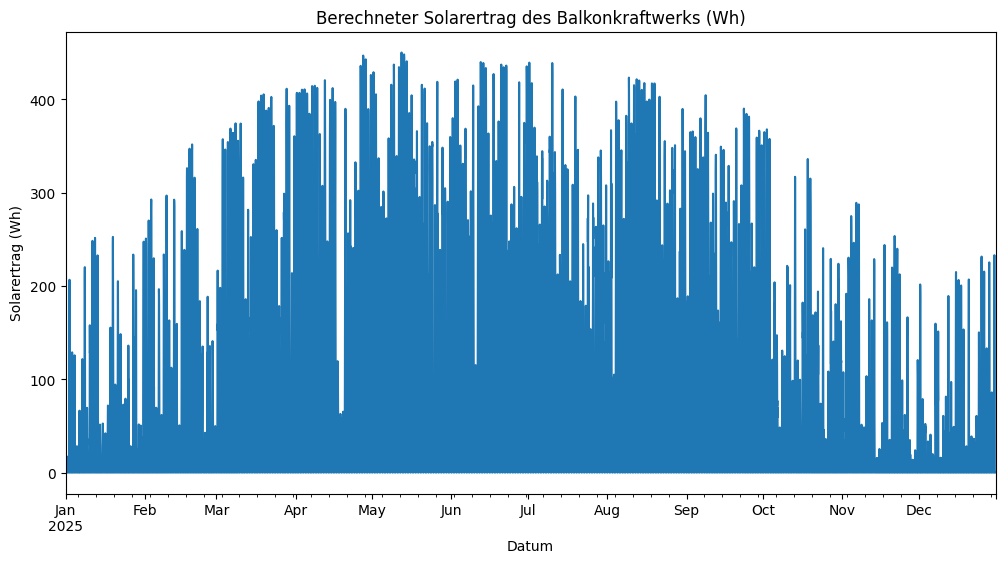

In [125]:
# Berechnung der Globalstrahlung auf der Fläche des Balkonkraftwerks unter Berücksichtigung der Neigung und Ausrichtung
df['POA_Global_calculated'] = pvlib.irradiance.get_total_irradiance(
    surface_tilt=balkonkraftwerk_tilt,          # Neigungswinkel in Grad
    surface_azimuth=balkonkraftwerk_azimuth,    # Ausrichtung in Grad (Azimut)
    dni=df['Direct_Radiation'],                 # Direktstrahlung in Watt pro m2
    ghi=df['Global_Radiation'],                 # Globalstrahlung in Watt pro m2
    dhi=df['Diffuse_Radiation'],                # Diffusstrahlung in Watt pro m2
    solar_zenith=df['apparent_zenith'],         # Zenithwinkel der Sonne in Grad
    solar_azimuth=df['azimuth']                 # Azimutwinkel der Sonne in Grad
)['poa_global']

# Berechnung der Leistung des Balkonkraftwerks unter Berücksichtigung der Fläche, des Wirkungsgrads
# und der Globalstrahlung auf der Fläche
df['solar_yield_Wh'] = df['POA_Global_calculated'] * balkonkraftwerk_fläche * balkonraftwerk_wirkungsgrad

# plotten der berechneten Solarerträge über die Zeit
df['solar_yield_Wh'].plot(figsize=(12, 6),
                           title='Berechneter Solarertrag des Balkonkraftwerks (Wh)',
                           ylabel='Solarertrag (Wh)',
                           xlabel='Datum')
